# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# Load the required Libraries

In [1]:
import pickle
import csv
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import glob
import math
from scipy import ndimage
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import DataSet
import time

random.seed()

---
## Step 0: Load The Data

### The dataset is loaded in the traffic_sign_data class  __init__ method

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

# Step0 and Step1: Load Data, Preprocess, Augment, Visualize Class

In [2]:
# This class is for loading the data preprocessing, augmentation, graphs and histograms etc

class traffic_Sign_Data(object):
    def __init__(self,training_file, testing_file, sign_names_file):

        self.read_pickle_files(training_file, testing_file)
        self._read_sign_names(sign_names_file)
        
                    
    def read_pickle_files(self,training_file,testing_file):
        with open(training_file, mode = 'rb') as f:
            self._train = pickle.load(f)
        with open(testing_file, mode='rb') as f:
            self._test = pickle.load(f)
            
        self._X_train = self._train['features']
        self._y_train = self._train['labels']
        self._X_test = self._test['features']
        self._y_test = self._test['labels']
        self._num_classes = len(np.unique(self._y_train))
        self._img_shape = self._X_train[0].shape
        
    def _read_sign_names(self, sign_names_file):
        self._label_sign_names = {}
        with open(sign_names_file) as f:
            reader = csv.DictReader(f)
            for row in reader:
#                 print (row['ClassId'], row['SignName'])
# The label numbers are the keys and the names of the signs corresponding to the labels are the values
                self._label_sign_names[int(row['ClassId'])] = row['SignName']
    
    def _num_train(self):
        # Returns the number of training examples
        return len(self._X_train)
    
    def _num_test(self):
        # Returns the number of testing examples
        return len(self._X_test)
    
    def _image_shape(self):
        # Returns the shape of the image
        return self._X_train[0].shape
    
    def _get_dataset_train(self):
        # Returns the train dataset
        return self._X_train, self._y_train
    
    def _get_dataset_test(self):
        # Returns the test dataset
        return self._X_test, self._y_test
    
    def _plot_histogram(self,labels_dataset,title):
        # Plots the histogram for the number of samples for each class
        count_classes = Counter(labels_dataset)
        x_label_names = [self._label_sign_names[i] for i in range(self._num_classes)]
        frequency = [count_classes[i] for i in range(self._num_classes)]
        plt.figure(figsize= (12,8))
        plt.bar(range(len(x_label_names)),height = frequency)
        plt.xticks(range(len(x_label_names)), x_label_names, size='medium', rotation = 90)
        plt.xlabel('Traffic Sign Names')
        plt.ylabel('Number of Samples')
        plt.title(title)
        plt.show()
        plt.clf()
        
    def _convert_grayscale(self, images):
        # Converts a set of images into grayscale
        gray_images = np.array([cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) for image in images])
        return gray_images
    
    def _convert_grayscale_individual(self, image):
        # Converts a single image that is passed as an argument to grayscale
        return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    def _histogram_equalization(self, images):
        # Does histogram equalization of images and converts them such that contrast in the images
        # is increased, this way we can isolate more features in the images
        hist_equalize_images = np.array([cv2.equalizeHist(image) for image in images])
        return hist_equalize_images
    
    def _histogram_equalization_individual(self, image):
        # Does the histogram equalization on inividual image
        return cv2.equalizeHist(image)
    
    def _normalize_images(self, images):
        # Subtracts the mean of the pixels divides by the standard deviation of the pixels
        normalized_images = (images - np.mean(images))
        normalized_images = norm_images / np.std(norm_images)
        return normalized_images
    
    def _shift_images(self,images, neg_shift = -2, pos_shift = 2):
        # This function takes a batch of images and shifts them by a little to the left and right so
        # that we can account for such variations in the real world data or the test set
        shifted_images = np.array([self._shift_image_individual(image) for image in images])
        return shifted_images
        
    def _rotate_images(self, images, anti_clock = -15, clock = 15):
        # This functions takes a batch of images and rotates each image by a specified amount similar to
        # the above function
        rotated_images = np.array([self._rotate_image_individual(image) for image in images])
        return rotated_images
    
    def _shift_image_individual(self,image, neg_shift = -2, pos_shift = 2):
        # Takes an image and returns the shifted image given the max negative and max positive shift
        return ndimage.interpolation.shift(image, [random.randrange(neg_shift, pos_shift), 
                                                   random.randrange(neg_shift, pos_shift),0])
         
    def _rotate_image_individual(self, image, anti_clock = -15, clock = 15):
        # Takes an image and returns the rotated image given the max anti-clockwise and max clockwise rotation
        return ndimage.interpolation.rotate(image, random.randrange(anti_clock,clock), reshape = False)
    
    def _generate_one_image_per_class(self):
        # This function generates one image for each class so that we can plot and see how
        # each class looks like
        labels = self._y_train
        idx_image = []
        for i in range(self._num_classes):
            for idx,label in enumerate(labels):
                if (i == label):
                    idx_image.append(idx)
                    break
        
        if len(self._img_shape) > 2:
            num_channels = self._img_shape[2]
            if num_channels > 1:
                one_image_per_class = np.array(self._X_train[idx_image]) # Returns a color image as such
            else:
                one_image_per_class = np.array(self._X_train[idx_image].reshape((-1,32,32))) # Returns a grayscale image by 
            return one_image_per_class
        
        else:
            one_image_per_class = np.array(self._X_train[idx_image])
            return one_image_per_class
    
    def _plot_images_one_per_class(self,images):
        # This function plots the images in a grid.
        num_images = len(images)
        rows , cols = self._grid_dims_for_subplots(num_images)
        f, axarr = plt.subplots(rows, cols, figsize = (32,32))
        for i in range(rows):
            for j in range(cols):
                if (i*cols + j) < num_images: 
                    axarr[i,j].axis('off')
                    axarr[i,j].imshow(images[i*(cols) + j])
                    axarr[i,j].set_title(self._label_sign_names[i*(cols) + j])
                
    def _plot_images(self, images):
        num_images = len(images)
        rows , cols = self._grid_dims_for_subplots(num_images)
        f, axarr = plt.subplots(rows, cols, figsize = (32,32))
        for i in range(rows):
            for j in range(cols):
                if (i*(cols)+ j) < num_images:
                    axarr[i,j].axis('off')
                    axarr[i,j].imshow(images[i*(cols) + j])
                    
    def _plot_predicted_images(self, images, predictions):
        # This function plots the images in a grid with row length as 5
        num_images = len(images)
        rows , cols = self._grid_dims_for_subplots(num_images)
        f, axarr = plt.subplots(rows, cols, figsize = (32,32))
        for i in range(rows):
            for j in range(cols):
                axarr[i,j].axis('off')
                axarr[i,j].imshow(images[i*(cols) + j])
                #axarr[i,j].set_title(self._label_sign_names[prediction[i*(cols-1) + j]])
        
    def _grid_dims_for_subplots(self,num_images):
        # This function computes the grid dimensions for the subplots
        cols = 5
        rows = math.ceil(num_images/cols)
        return rows, cols
    
    def _preprocess_image_individual(self,image):
        img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        img = cv2.equalizeHist(img)
        img = img[..., np.newaxis]
        return img
    
    def _preprocess_images(self,images):
        return np.array([self._preprocess_image_individual(image) for image in images])
    
        
    def _plot_image_individual(image):
        plt.imshow(image)
        
    def _shift_and_rotate_images(self, images, labels, pos_shift = 2, neg_shift = -2, 
                                 pos_rotate = 15, neg_rotate = -15):
        X_train_augmented = []
        y_train_augmented = []
        
        for image, label in zip(images, labels):
            for i in range(2):
                aug_shift_x = ndimage.interpolation.shift(image, 
                                                [random.randrange(neg_shift, pos_shift), 
                                                 random.randrange(neg_shift, pos_shift), 0])
                X_train_augmented.append(aug_shift_x)
                y_train_augmented.append(label)
    
                aug_rotate_x = ndimage.interpolation.rotate(image, 
                                                 random.randrange(neg_rotate,pos_rotate), 
                                                 reshape=False)
                X_train_augmented.append(aug_rotate_x)
                y_train_augmented.append(label)
                
        _X_augmented = np.array(X_train_augmented)
        _y_augmented = np.array(y_train_augmented)
        
        return _X_augmented, _y_augmented


    def _augment_image(self, image,pos_shift = 2, neg_shift = -2, pos_rotate = 15, neg_rotate = -15):

        if random.choice([False, True]):
            aug_image = ndimage.interpolation.shift(image, 
                                                [random.randrange(neg_shift, pos_shift), 
                                                 random.randrange(neg_shift, pos_shift), 0])
        else:
            aug_image = ndimage.interpolation.rotate(image, 
                                                 random.randrange(neg_rotate,pos_rotate), 
                                                 reshape=False)
        return aug_image


    def _generate_augmented_images_train(self):
        # This function generates new images by shifting and rotating the original images.
        # It only augments those images that belong to an underrepresented class(with images < 1000)
        # After augmentation each class consists of atleast 2500 images
        
        count_classes = Counter(self._y_train)
        labels = self._y_train.tolist()
        required_samples = [int(math.ceil(2500/count_classes[y])) for y in range(self._num_classes)]
        X_augmented = []
        y_augmented = []
        for idx, label in enumerate(labels, start=0):
            if required_samples[label] > 1:
                for i in range(required_samples[label]):
                    X_augmented.append(self._augment_image(self._X_train[idx]))
                    y_augmented.append(label)
        self._X_augmented = np.array(X_augmented)
        self._y_augmented = np.array(y_augmented)
    
    def _train_validation_split(self, images, labels):
        data , label = shuffle(images, labels)
        train_data ,validation_data,train_label,validation_label = train_test_split(data,label,
                                                                                       test_size=0.20,
                                                                                       random_state=10)
        return train_data, train_label, validation_data, validation_label
    
    def _get_dataset_train(self):
        return self._X_train, self._y_train
    
    def _get_dataset_train_validation(self):
        X_train, y_train, X_validation, y_validation = self._train_validation_split(self._X_train, self._y_train)
        return X_train, y_train, X_validation, y_validation
        
    def _get_new_train_dataset_augmented(self):
        _X_augmented = np.append(np.array(self._X_train), np.array(self._X_augmented), axis = 0)
        _y_augmented = np.append(np.array(self._y_train), np.array(self._y_augmented), axis = 0)
        return _X_augmented, _y_augmented
    
    
    def _get_augmented_preprocessed_dataset_train(self):
        self._generate_augmented_images_train()
        X_augmented, y_augmented = self._get_new_train_dataset_augmented()
        X_aug_pre = self._preprocess_images(X_augmented)
        y_aug_pre = y_augmented 
    
        return X_aug_pre, y_aug_pre
    
    def _get_augmented_dataset_train_validation_test(self):
        self._generate_augmented_images_train()
        X_augmented, y_augmented = self._get_new_train_dataset_augmented()
        X_train, y_train, X_validation, y_validation = self._train_validation_split(X_augmented, y_augmented)
        
        return X_train, y_train, X_validation, y_validation,self._X_test, self._y_test
    
    def _get_dataset_test(self):
        return self._X_test, self._y_test
    
    def _get_preprocessed_dataset_test(self):
        X_pre_test = self._preprocess_images(self._X_test)
        y_pre_test = self._y_test
        
        return X_pre_test, y_pre_test
    
    def _get_train_validation_augmented_preprocessed_dataset(self):
        self._generate_augmented_images_train()
        X_augmented, y_augmented = self._get_new_train_dataset_augmented()
        X_aug_pre = self._preprocess_images(X_augmented)
        y_aug_pre = y_augmented
        
        X_train, y_train, X_validation, y_validation = self._train_validation_split(X_aug_pre, y_aug_pre)
        
        return X_train, y_train, X_validation, y_validation
    
    
    def _get_train_validation_test_dataset_augmented_preprocessed(self):
        
        X_train, y_train, X_validation, y_validation = self._get_train_validation_augmented_preprocessed_dataset()
        X_test, y_test = self._get_preprocessed_dataset_test()
        
        return X_train, y_train, X_validation, y_validation, X_test, y_test
    
    def _get_trial_images(self,directory):
        images = [cv2.imread(directory + "/" + name) for name in os.listdir(directory)]
        y_images = np.array([3,25,18,34,38,12,1,11])
        return np.asarray(images), y_images
            
    def _get_preprocessed_trial_images(self, directory):
        images, labels = self._get_trial_images(directory)
        gray_images = self._preprocess_images(images)
        return gray_images, labels

In [3]:
# Creating a traffic sign data class object. This object is used to perform all kinds of
# operations on the data like augmentation, preprocessing, graphs and other histograms
tsd = traffic_Sign_Data("traffic-signs-data/train.p", "traffic-signs-data/test.p", "signnames.csv")

In [4]:
    # print the train and test dataset count (This is the raw dataset before preprocessing and augmentation)

    print("Training examples {}".format(tsd._num_train()))
    print("Test examples {}".format(tsd._num_test()))
    print("Image shape {}".format(tsd._image_shape()))
    print("Number of traffic sign classes {}".format(tsd._num_classes))

Training examples 39209
Test examples 12630
Image shape (32, 32, 3)
Number of traffic sign classes 43


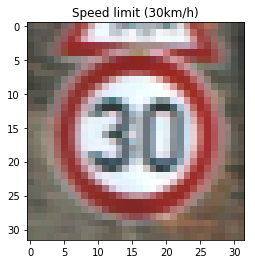

In [5]:
# Data Visualization(One of the traffic Signs)
plt.imshow(tsd._X_train[1000]) # Traffic Sign
plt.title(tsd._label_sign_names[tsd._y_train[1000]]) # Traffic Sign Name

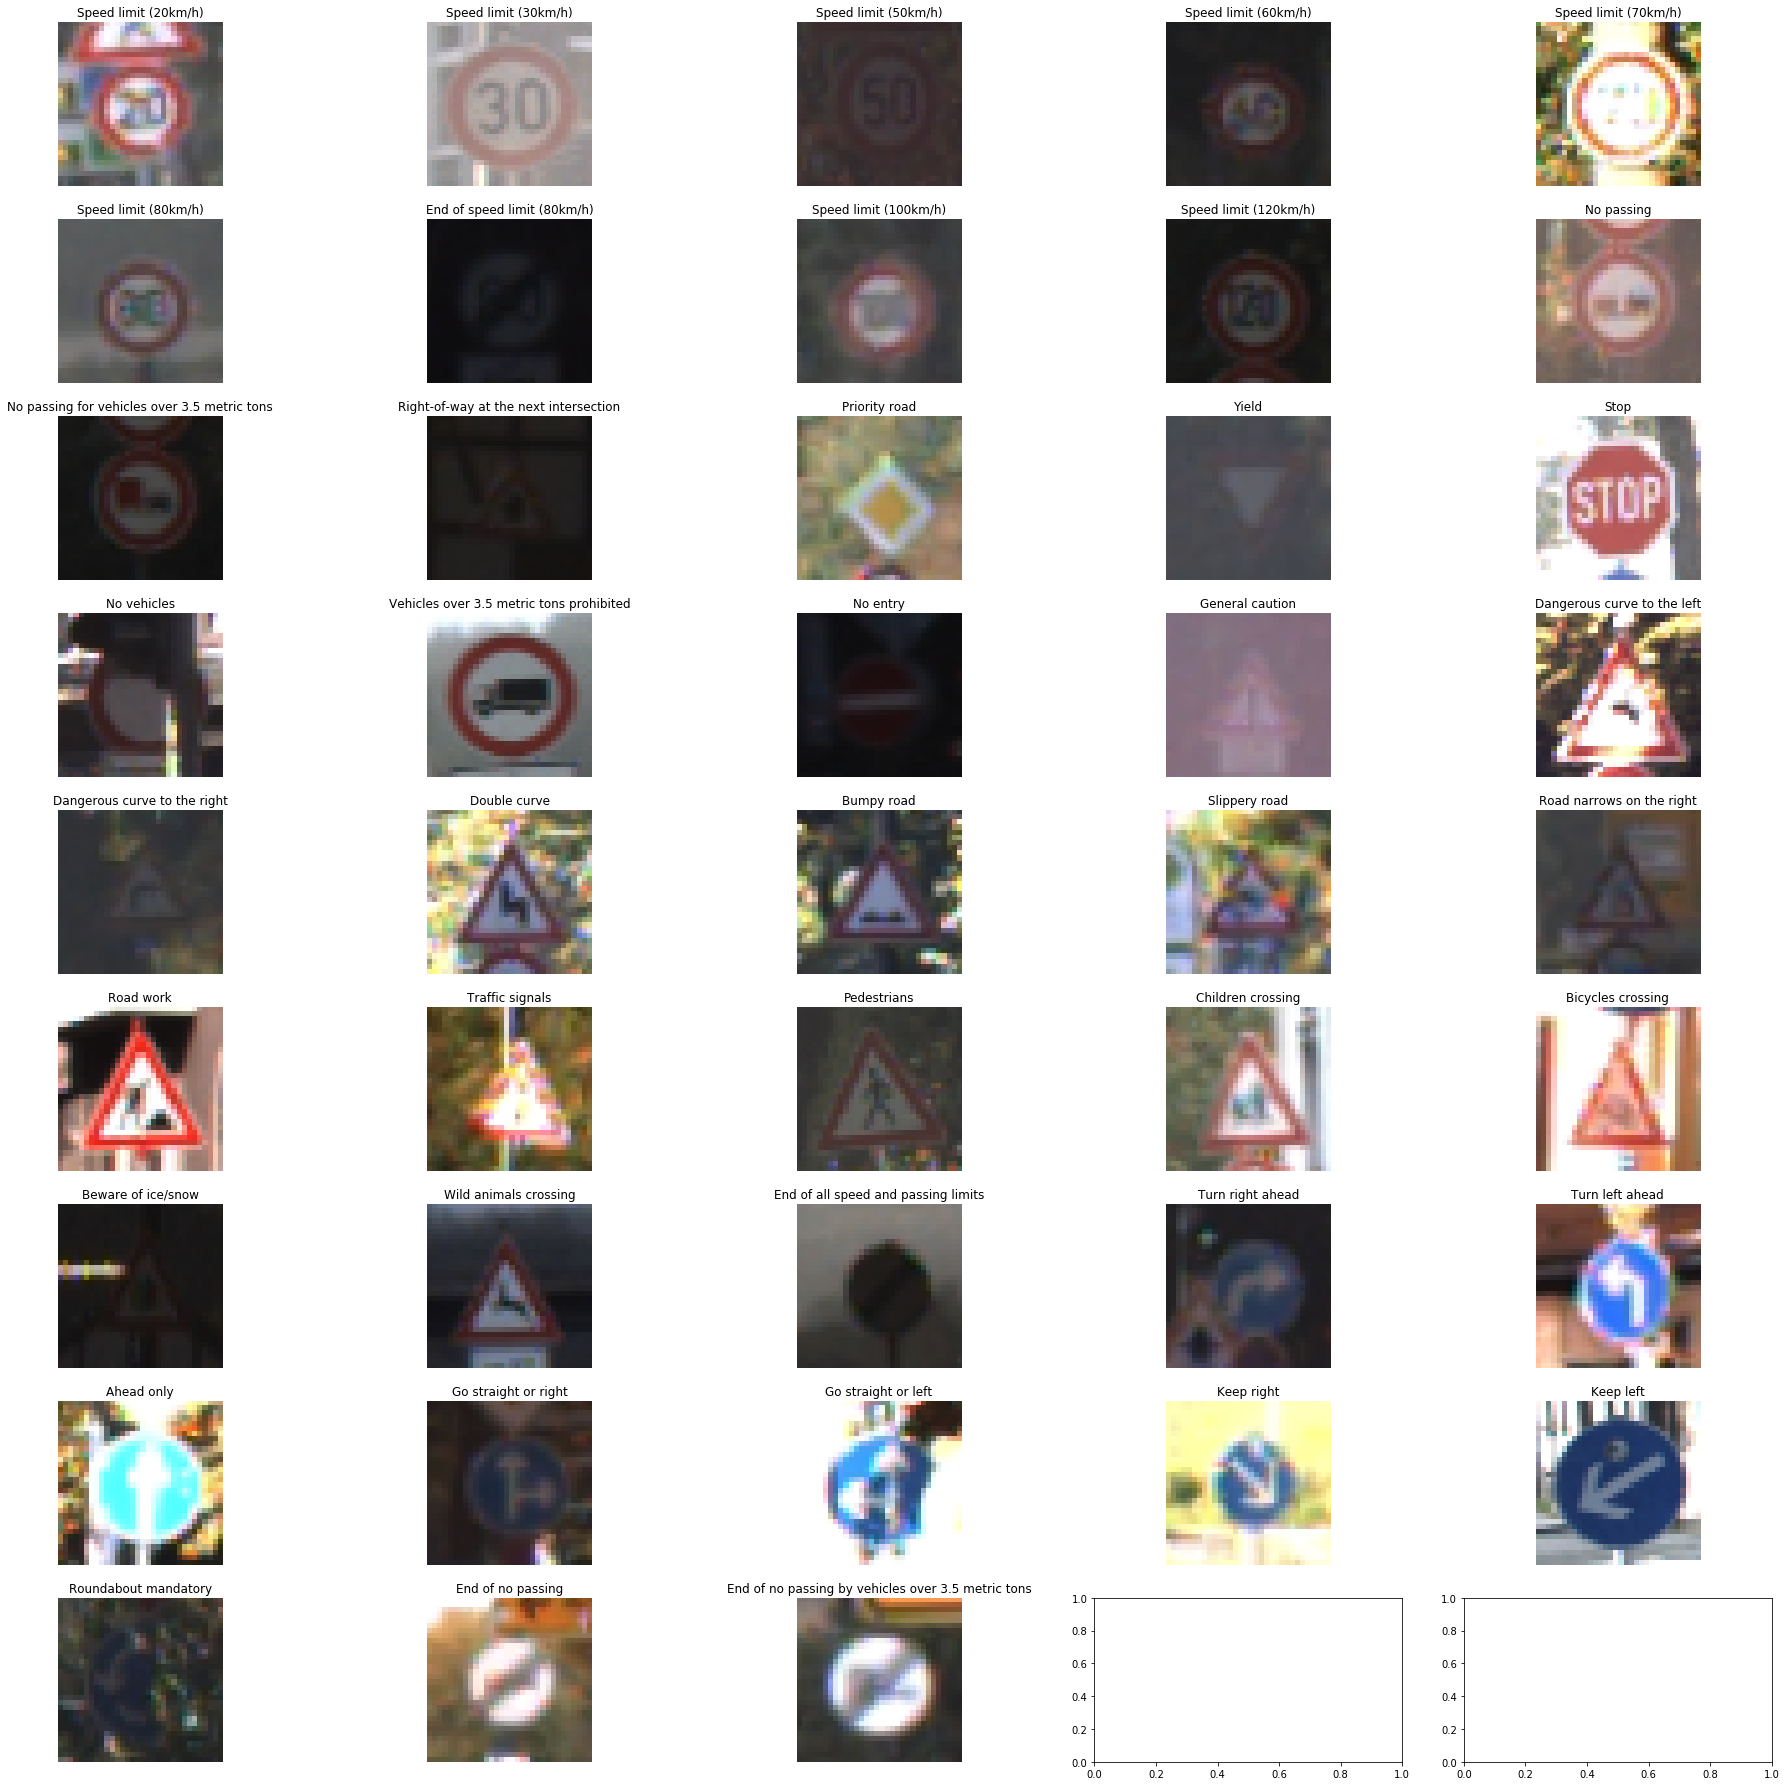

In [6]:
# Below is a plot of one image per class in the dataset
images_one_per_class = tsd._generate_one_image_per_class()
tsd._plot_images_one_per_class(images_one_per_class)

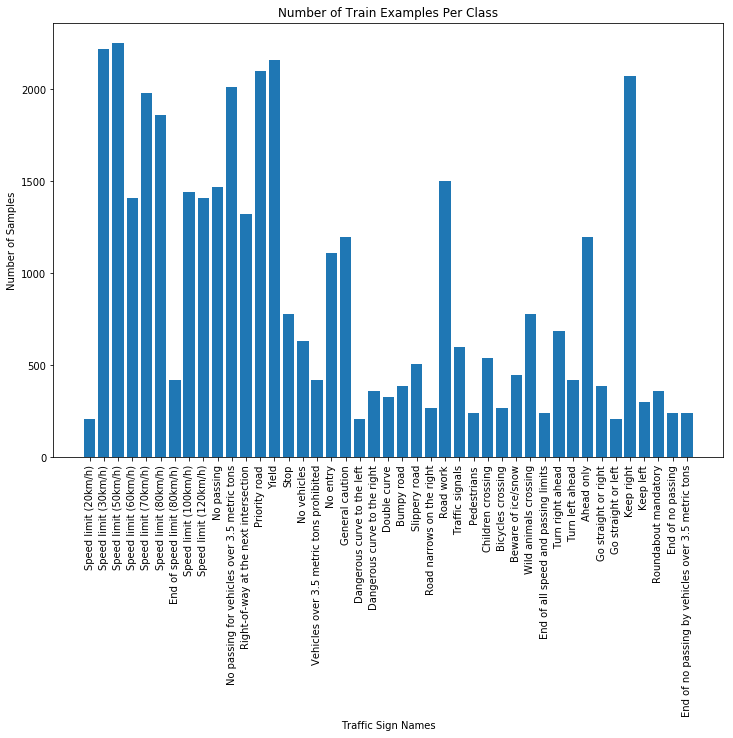

In [7]:
# Displaying the histogram of the number of images per class in the train data.
# This gives us an idea of how much data augmentation is needed in the dataset. Any 
# underrepresented class could be augmented adequately to produce a more robust model.

X_train, y_train = tsd._get_dataset_train()
tsd._plot_histogram(labels_dataset = y_train, title="Number of Train Examples Per Class") # Train Examples histogram


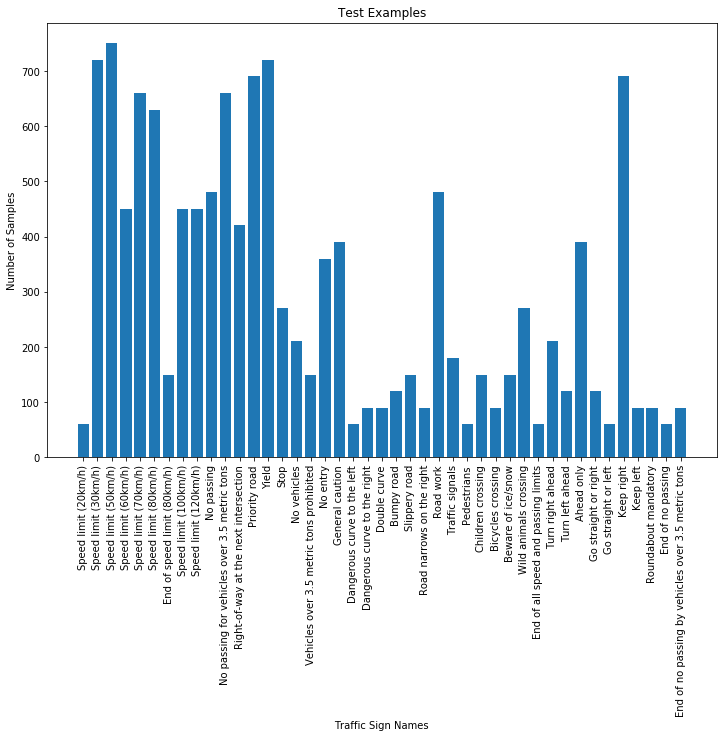

In [8]:
# Displaying the histogram of the number of images per class in the test data.
# This gives us an idea of how much data augmentation is needed in the dataset. Any 
# underrepresented class could be augmented adequately to produce a more robust model.
X_test, y_test = tsd._get_dataset_test()
tsd._plot_histogram(labels_dataset = y_test, title = "Test Examples") # Test Examples histogram

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

** Preprocessing **

The preprocessing techniques that I employed in the project are:

1. Grayscale conversion of images
2. Histogram equalization of the grayscale images

I tried these techniques as in most of the articles I had read about preprocessing included mainly these two techniques. Also, Yann Lecun's paper on traffic sign classification suggests both these techniques apart from a slew of others.

There are other techniques like normalization of images and whitening of the images using PCA but I haven't got much gain in validation and test accuracy employing these other techniques.

** Augmentation **

** Original Dataset: **

The original dataset has 39202 images with varying number of images per class.

** Additional Data: **

I thought of a number of data augmentation techniques to perform on the original dataset.

1. Shift the images to the left and right by a small amount ([-2,2] pixels).
2. Rotate the images by a small positive or negative angle ([-15,15] degrees).

The above techniques could be very useful as convolutional neural network architectures have built in invariance to small translations and rotations. When such deformations are not present in the dataset, adding them synthetically will yield much more robust results.

Once the data augmentation techniques are decided I thought of multiple ways to apply these preprocessing techniques.

1. **Method-1:**

    Choose only those classes that have very less number of training examples(<1000) and then randomly perturb them in location or rotate them so that the number of images in that class is atleast a 2500. That should be enough examples to cover many variations of the images.
    
2. **Method-2:**

    Randomly perturb each image in the dataset and create as many images as 4 times the actual number of images.
    Final number of images in the dataset are 196045. These include the original 39202 images as well.
    The problem with this method is that there is stil class imbalance and it would create a classifier that would be biased towards the class with more number of examples.
    
    I decided to go with method-1 as the dataset now was huge with lots of new and variations of the images. Although, this method took significantly more time to train, with the availability of GPUs it did not make much difference as long as I got to a good accuracy.

    
The dataset generated using method-1 is more balanced in terms of the class composition. The number of images for each class is now over a 2500 and all the classes have close to the same number of images whereas in the dataset in method-2 is a bit skewed in terms of class composition. All the classes have images over a 2500 but some classes have a lot more number of images compared to others.
    
Using the Method-1 my validation accuracy jumped from around 95% when trained without augmentation to 98.1%

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

** Augmentation **

** Original Dataset: **

The original dataset has 39202 images with varying number of images per class.

** Additional Data: **

I thought of a number of data augmentation techniques to perform on the original dataset.

1. Shift the images to the left and right by a small amount ([-2,2] pixels).
2. Rotate the images by a small positive or negative angle ([-15,15] degrees).

The above techniques could be very useful as convolutional neural network architectures have built in invariance to small translations and rotations. When such deformations are not present in the dataset, adding them synthetically will yield much more robust results.

Once the data augmentation techniques are decided I thought of multiple ways to apply these preprocessing techniques.

1. **Method-1:**

    Choose only those classes that have very less number of training examples(<1000) and then randomly perturb them in location or rotate them so that the number of images in that class is atleast a 2500. That should be enough examples to cover many variations of the images.
    
2. **Method-2:**

    Randomly perturb each image in the dataset and create as many images as 4 times the actual number of images.
    Final number of images in the dataset are 196045. These include the original 39202 images as well.
    The problem with this method is that there is stil class imbalance and it would create a classifier that would be biased towards the class with more number of examples.
    
    I decided to go with method-1 as the dataset now was huge with lots of new and variations of the images. Although, this method took significantly more time to train, with the availability of GPUs it did not make much difference as long as I got to a good accuracy.

    
The dataset generated using method-1 is more balanced in terms of the class composition. The number of images for each class is now over a 2500 and all the classes have close to the same number of images whereas in the dataset in method-2 is a bit skewed in terms of class composition. All the classes have images over a 2500 but some classes have a lot more number of images compared to others.
    
Using the Method-1 my validation accuracy jumped from around 95% when trained without augmentation to 98.1%

### Train, Validation and Test data:

After creating the new dataset, the train_test_split function from the sklearn module is used to split the dataset randomly into 80-20. i.e., 80% training data and 20% validation data.

The data is split after preprocessing is done on the entire dataset.

In [6]:
print ("Starting Augmentation and Preprocessing...")
X_train, y_train, X_validation, y_validation, X_test, y_test = tsd._get_train_validation_test_dataset_augmented_preprocessed()
print (len(X_train), len(y_train))
print ("Done with Augmentation...")
print ()
print("Shape of Augmented Train dataset is {} ".format(X_train.shape))
print("Shape of Augmented Validation dataset is {} ".format(X_validation.shape))
print("Shape of Augmented Test dataset is {} ".format(X_test.shape))

Starting Augmentation and Preprocessing...
135620 135620
Done with Augmentation...

Shape of Augmented Train dataset is (135620, 32, 32, 1) 
Shape of Augmented Validation dataset is (33905, 32, 32, 1) 
Shape of Augmented Test dataset is (12630, 32, 32, 1) 


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


** Answer: **

** Final Architecture **

1. Convolution - Kernal Size(5x5) - Input(32x32x1) - Output(32x32x32)
2. ReLU
3. Convolution - Kernal Size(4x4) - Input(32x32x32) - Output(16x16x64)
4. ReLU
5. Convolution - Kernal Size(3x3) - Input(16x16x64) - Output(8x8x128)
6. ReLU
7. Convolution - Kernal Size(2x2) - Input(8x8x128) - Output(8x8x256)
8. ReLU
9. Flatten - Input(8x8x256) - Output(16384)
10. Dropout(keep probability - 0.75)
11. Fully Connected - Input(16384) - Output(512)
12. ReLU
13. Dropout
14. Fully Connected - Input(512) - Output(128)
15. ReLU
16. Fully Connected - Input(128) - Output(43)

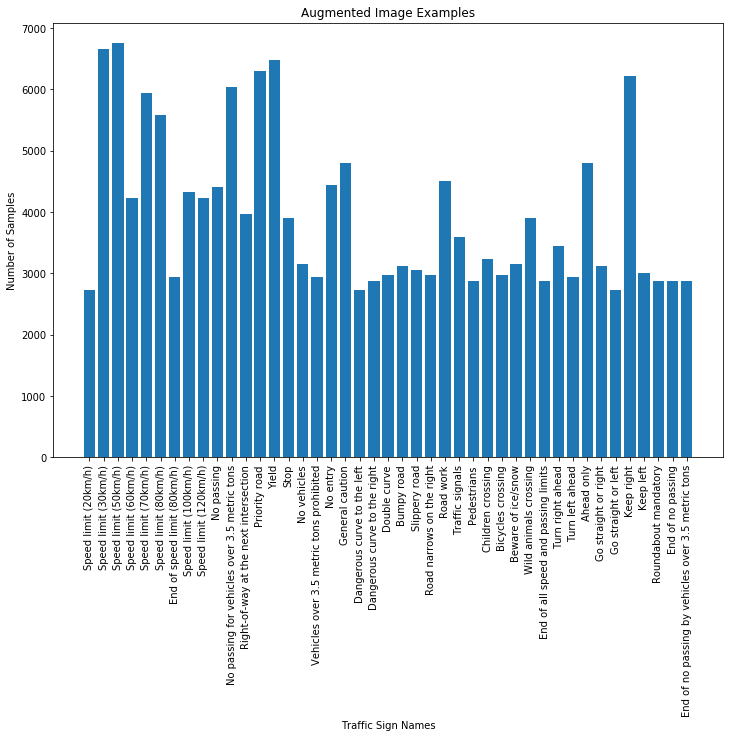

In [10]:
# Histogram of Augmented images(# of new images per class generated)
y_aug = np.append(y_train,y_validation)
tsd._plot_histogram(labels_dataset= y_aug, title = "Augmented Image Examples")

In [7]:
import numpy as np
import tensorflow as tf

class Model(object):
    
    def __init__(self,Epochs, Batch_Size):
        tf.set_random_seed(0.0)
        self._X = tf.placeholder(tf.float32, (None, 32, 32, 1))
        self._y = tf.placeholder(tf.int32, (None))
        self._one_hot_y = tf.one_hot(self._y, 43)
        # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
        self._pkeep = tf.placeholder(tf.float32)
        self._lr = tf.placeholder(tf.float32)
        self.epochs = Epochs
        self.batch_size = Batch_Size
        self.constant_learning_rate = 0.001
        self._validation_accuracy = []
        self._validation_loss = []
        
    
    def LeNet(self): 
        # Arguments used for tf.truncated_normal, randomly defines variables for 
        # the weights and biases for each layer
        mu = 0
        sigma = 0.1

        # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(self._X, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        # SOLUTION: Activation.
        conv1 = tf.nn.relu(conv1)

        # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

        # SOLUTION: Activation.
        conv2 = tf.nn.relu(conv2)

        # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
        fc0   = flatten(conv2)

        # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b

        # SOLUTION: Activation.
        fc1    = tf.nn.relu(fc1)

        # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b

        # SOLUTION: Activation.
        fc2    = tf.nn.relu(fc2)

        # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_W) + fc3_b

        return logits

    def LeNet_modified(self):
        
        # Arguments used for tf.truncated_normal, randomly defines 
        # variables for the weights and biases for each layer
        mu = 0
        sigma = 0.1

        # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x32.
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,32), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(32))
        conv1   = tf.nn.conv2d(self._X, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

        # SOLUTION: Activation.
        conv1 = tf.nn.relu(conv1)

        # SOLUTION: Layer 2: Convolutional. Input = 32x32x32. Output = 16x16x64.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 32, 64), mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(64))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 2, 2, 1], padding='SAME') + conv2_b

        # SOLUTION: Activation.
        conv2 = tf.nn.relu(conv2)

        # SOLUTION: Layer 3: Convolutional. Input = 16x16x64. Output = 8x8x128.
        conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
        conv3_b = tf.Variable(tf.zeros(128))
        conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 2, 2, 1], padding='SAME') + conv3_b

        # SOLUTION: Activation.
        conv3 = tf.nn.relu(conv3)
        
        # SOLUTION: Layer 4: Convolution. Input = 8x8x128 Output = 8x8x256
        conv4_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 128, 256), mean = mu, stddev = sigma))
        conv4_b = tf.Variable(tf.zeros(256))
        conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
        
        # SOLUTION: Activation.
        conv4 = tf.nn.relu(conv4)
        
        # SOLUTION: Flatten. Input = 8x8x256. Output = 16384.
        fc0 = flatten(conv4)

        # SOLUTION: dropout
        fc0_d = tf.nn.dropout(fc0, self._pkeep)

        # SOLUTION: Layer 4: Fully Connected. Input = 16384. Output = 512.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(16384, 512), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(512))
        fc1   = tf.matmul(fc0_d, fc1_W) + fc1_b

        # SOLUTION: Activation.
        fc1    = tf.nn.relu(fc1)

        # SOLUTION: Dropout.
        fc1_d = tf.nn.dropout(fc1, self._pkeep)

        # SOLUTION: Layer 5: Fully Connected. Input = 512. Output = 128.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(512,128), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(128))
        fc2    = tf.matmul(fc1_d, fc2_W) + fc2_b

        # SOLUTION: Activation.
        fc2    = tf.nn.relu(fc2)

        # SOLUTION: Layer 6: Fully Connected. Input = 128. Output = 43.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_W) + fc3_b

        return logits
    

    def _training_features(self):
        self._logits = self.LeNet_modified()
        self._softmax_of_logits = tf.nn.softmax(self._logits)
        self._cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self._logits, self._one_hot_y)
        self._loss_operation = tf.reduce_mean(self._cross_entropy)
        self._optimizer = tf.train.AdamOptimizer(learning_rate = self._lr)
        self._training_operation = self._optimizer.minimize(self._loss_operation)
        self._correct_prediction = tf.equal(tf.argmax(self._logits, 1), tf.argmax(self._one_hot_y, 1))
        self._accuracy_operation = tf.reduce_mean(tf.cast(self._correct_prediction, tf.float32))
        self._labels_softmax_prob = tf.nn.softmax(self._logits)
        self._prediction_label = tf.argmax(self._labels_softmax_prob, 1)
        self._sess = None
        self._saver = tf.train.Saver()
    
    def _trainer(self, X_train_data, y_train_data,X_validation_data, y_validation_data):
        self._training_features()
        with tf.Session() as self._sess:
            self._sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_data)
        
            print("Training...")
            print()
            for i in range(self.epochs):
                X_train_data, y_train_data = shuffle(X_train_data, y_train_data)
                start_time = time.time()
                for offset in range(0, num_examples, self.batch_size):                    
                    # learning rate decay
                    max_learning_rate = 0.003
                    min_learning_rate = 0.0001
                    decay_speed = 2000
                    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate)*math.exp(-i/decay_speed)
                    
                    batch_x, batch_y = X_train_data[offset:offset+self.batch_size], y_train_data[offset:offset+self.batch_size]
                    self._sess.run(self._training_operation, feed_dict={self._X: batch_x, self._y: batch_y, self._pkeep: 0.75,self._lr:learning_rate})

                validation_accuracy, validation_loss = self.evaluate(X_validation_data, y_validation_data)
                self._validation_accuracy.append(validation_accuracy)
                self._validation_loss.append(validation_loss)
                if max(self._validation_accuracy) > 0.991:
                    break
                #end_time = time.time()
                #time_taken = end_time - start_time
                print("EPOCH {} ".format(i+1),"Validation Accuracy = {:.3f}, ".format(validation_accuracy), "Validation loss = {:.3f}".format(validation_loss))
#                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
#                print("Validation loss = {:.3f}".format(validation_loss))
#                 print("Time taken for the Epoch: ", time_taken, " seconds")
#                 print()
                
            """
            test_accuracy, test_loss = self.evaluate(X_test, y_test)
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            print("Test loss = {:.3f}".format(test_loss))
            print()
            """
            print("Max Validation Accuracy is {} ".format(max(self._validation_accuracy)))
            print("Model Optimized")
            print()
            self._saver.save(self._sess, './lenet')
            print("Model saved")
            
    def evaluate(self,X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        total_loss = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, self.batch_size):
            batch_x, batch_y = X_data[offset:offset+self.batch_size], y_data[offset:offset+self.batch_size]
            accuracy , loss = sess.run([self._accuracy_operation,self._loss_operation], feed_dict={self._X: batch_x, self._y: batch_y, self._pkeep:1.0})
            total_accuracy += (accuracy * len(batch_x))
            total_loss += loss
        return total_accuracy/num_examples, total_loss
    
    
    def evaluate_test_accuracy(self,X_data, y_data):
        with tf.Session() as sess:
            self._saver.restore(sess, tf.train.latest_checkpoint('.'))
            test_accuracy, test_loss = self.evaluate(X_data, y_data)
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            print("Test loss = {:.3f}".format(test_loss))
            print()
        
    def evaluate_trial_accuracy(self,X_data, y_data):
        with tf.Session() as sess:
            self._saver.restore(sess, tf.train.latest_checkpoint('.'))
            trial_accuracy, trial_loss = self.evaluate(X_data, y_data)
            print("Trial Accuracy = {:.3f}".format(trial_accuracy))
            print("Trial loss = {:.3f}".format(trial_loss))
            print()

In [8]:
model = Model(50,256)

In [9]:
model._trainer(X_train,y_train,X_validation,y_validation)

Training...

EPOCH 1  Validation Accuracy = 0.040,  Validation loss = 494.139
EPOCH 2  Validation Accuracy = 0.289,  Validation loss = 373.636
EPOCH 3  Validation Accuracy = 0.898,  Validation loss = 44.199
EPOCH 4  Validation Accuracy = 0.950,  Validation loss = 22.595
EPOCH 5  Validation Accuracy = 0.967,  Validation loss = 14.513
EPOCH 6  Validation Accuracy = 0.967,  Validation loss = 14.339
EPOCH 7  Validation Accuracy = 0.979,  Validation loss = 9.502
EPOCH 8  Validation Accuracy = 0.979,  Validation loss = 9.130
EPOCH 9  Validation Accuracy = 0.982,  Validation loss = 7.891
EPOCH 10  Validation Accuracy = 0.983,  Validation loss = 7.675
EPOCH 11  Validation Accuracy = 0.980,  Validation loss = 9.236
EPOCH 12  Validation Accuracy = 0.978,  Validation loss = 9.413
EPOCH 13  Validation Accuracy = 0.985,  Validation loss = 7.098
EPOCH 14  Validation Accuracy = 0.986,  Validation loss = 6.286
EPOCH 15  Validation Accuracy = 0.985,  Validation loss = 7.143
EPOCH 16  Validation Accurac

# Test Images and Prediction Accuracy

In [10]:
model.evaluate_test_accuracy(X_test, y_test)

Test Accuracy = 0.948
Test loss = 15.597



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**

I used the AdamOptimizer with a # of epochs as 50 and the batch size as 256. I also used a variable decay learning rate.

1. Batch Size = 256
2. Epochs = 50
3. Learning rate = starting at 0.003 with exponential decay
4. Dropout = 0.75 as the probability of keep, applied only on fully connected layers

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

** Answer **

I started experimenting on the LeNet model at first without any data preprocessing or augmentation.

** Results from the basic LeNet model without data augmentation**

1. Color images gave a validation accuracy of 96% and a test accuracy of 90%
2. Grayscale images gave a validation accuracy of 97% and a test accuracy of 91%
3. Grayscale and histogram equalization gave a validation accuracy of 97% and a test accuracy of 91%

** Results from the basic LeNet model with data augmentation **

1. Color images gave a validation accuracy of 97% and a test accuracy of 90%
2. Grayscale images gave a validation accuracy of 98% and a test accuracy of 91%
3. Grayscale and histogram equalization gave a validation accuracy of 98% and a test accuracy of 91%

Overall pretty similar results to the no data augmentation case.

** Results from the modified LeNet model with data augmentation **
I tried with many model architectures and the best that I found is the one mentioned earlier. On augmented and preprocessed dataset I implemented an early stopping criterion with the training stopping when a validation accuracy of 99.2% is achieved. This model gave me a test accuracy of 94.8%.

# Trial Images and Prediction Accuracy

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [11]:
"""
New trial images. In folders trial_images1 and trial_images2 folders
no_of_imgs1 = 8 # These 8 images are in trial_images1 folder with pixel size 32x32x3
no_of_imgs2 = 22 # in trial_images2 folder with different pixel sizes
The labels for these images have been marked manually. There are a few traffic signs
that are not present in the original dataset
"""

no_of_imgs = 30

images1 = [cv2.imread("trial_images1/" + name) for name in os.listdir("trial_images1")]
images2 = [cv2.imread("trial_images2/" + name) for name in os.listdir("trial_images2")]
dim = (32,32)

resized_images2 = [cv2.resize(image, dim, interpolation=cv2.INTER_AREA) for image in images2]

color_trial_images = np.array(images1 + resized_images2)
# The below dimensions of the image are(32x32).This necessary for plotting images using matplotlib
gray_trial_images = np.array([cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) for image in color_trial_images])
# The below dimensions of the image are(32x32x1). This is essential to pass to the Neural Network
gray_trial_images_X = gray_trial_images[...,np.newaxis]

"""
gray_trial_images_y = np.array([3,25,18,34,38,12,1,11,30,17,33,21,11,26,22,0,1,2,4,7,27,17,33,14,16,2,28,34,0,11])
# My computer ordering, there is another ordering for Google Cloud
"""
gray_trial_images_y = np.array([38,12,1,3,25,11,18,34,22,30,0,26,1,11,21,0,4,34,27,17,14,7,28,36,2,17,2,16,20,33])
# Google cloud version. Somehow the trial_images have different order in the cloud and my mac

In [12]:
# Prediction classes for the trial images 

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    # model evaluation
    prediction = tf.argmax(model._logits, 1)

    trial_prediction = sess.run(prediction, feed_dict={model._X:gray_trial_images_X, model._pkeep:1.0})

no_of_imgs = 30
for i in range(no_of_imgs):
    if (i%5 == 0 and i < no_of_imgs):
        print (" ")
    #tsd._plot_predicted_images(gray_images_, trial_prediction)
    print('Prediction: {} \t| {}'.format(trial_prediction[i], tsd._label_sign_names[trial_prediction[i]]))

 
Prediction: 38 	| Keep right
Prediction: 12 	| Priority road
Prediction: 1 	| Speed limit (30km/h)
Prediction: 3 	| Speed limit (60km/h)
Prediction: 25 	| Road work
 
Prediction: 11 	| Right-of-way at the next intersection
Prediction: 18 	| General caution
Prediction: 34 	| Turn left ahead
Prediction: 5 	| Speed limit (80km/h)
Prediction: 5 	| Speed limit (80km/h)
 
Prediction: 40 	| Roundabout mandatory
Prediction: 40 	| Roundabout mandatory
Prediction: 1 	| Speed limit (30km/h)
Prediction: 11 	| Right-of-way at the next intersection
Prediction: 7 	| Speed limit (100km/h)
 
Prediction: 0 	| Speed limit (20km/h)
Prediction: 40 	| Roundabout mandatory
Prediction: 18 	| General caution
Prediction: 12 	| Priority road
Prediction: 9 	| No passing
 
Prediction: 5 	| Speed limit (80km/h)
Prediction: 5 	| Speed limit (80km/h)
Prediction: 28 	| Children crossing
Prediction: 5 	| Speed limit (80km/h)
Prediction: 7 	| Speed limit (100km/h)
 
Prediction: 17 	| No entry
Prediction: 2 	| Speed li

In [14]:
# The accuracy on trial images
model.evaluate_trial_accuracy(gray_trial_images_X, gray_trial_images_y)

Trial Accuracy = 0.500
Trial loss = 5.442



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



** Answer **

The images chosen as trial have distinct colors in them that are not part of the original dataset. Also, there are a few traffic signs that have the same class names as in the dataset but have a different image. 

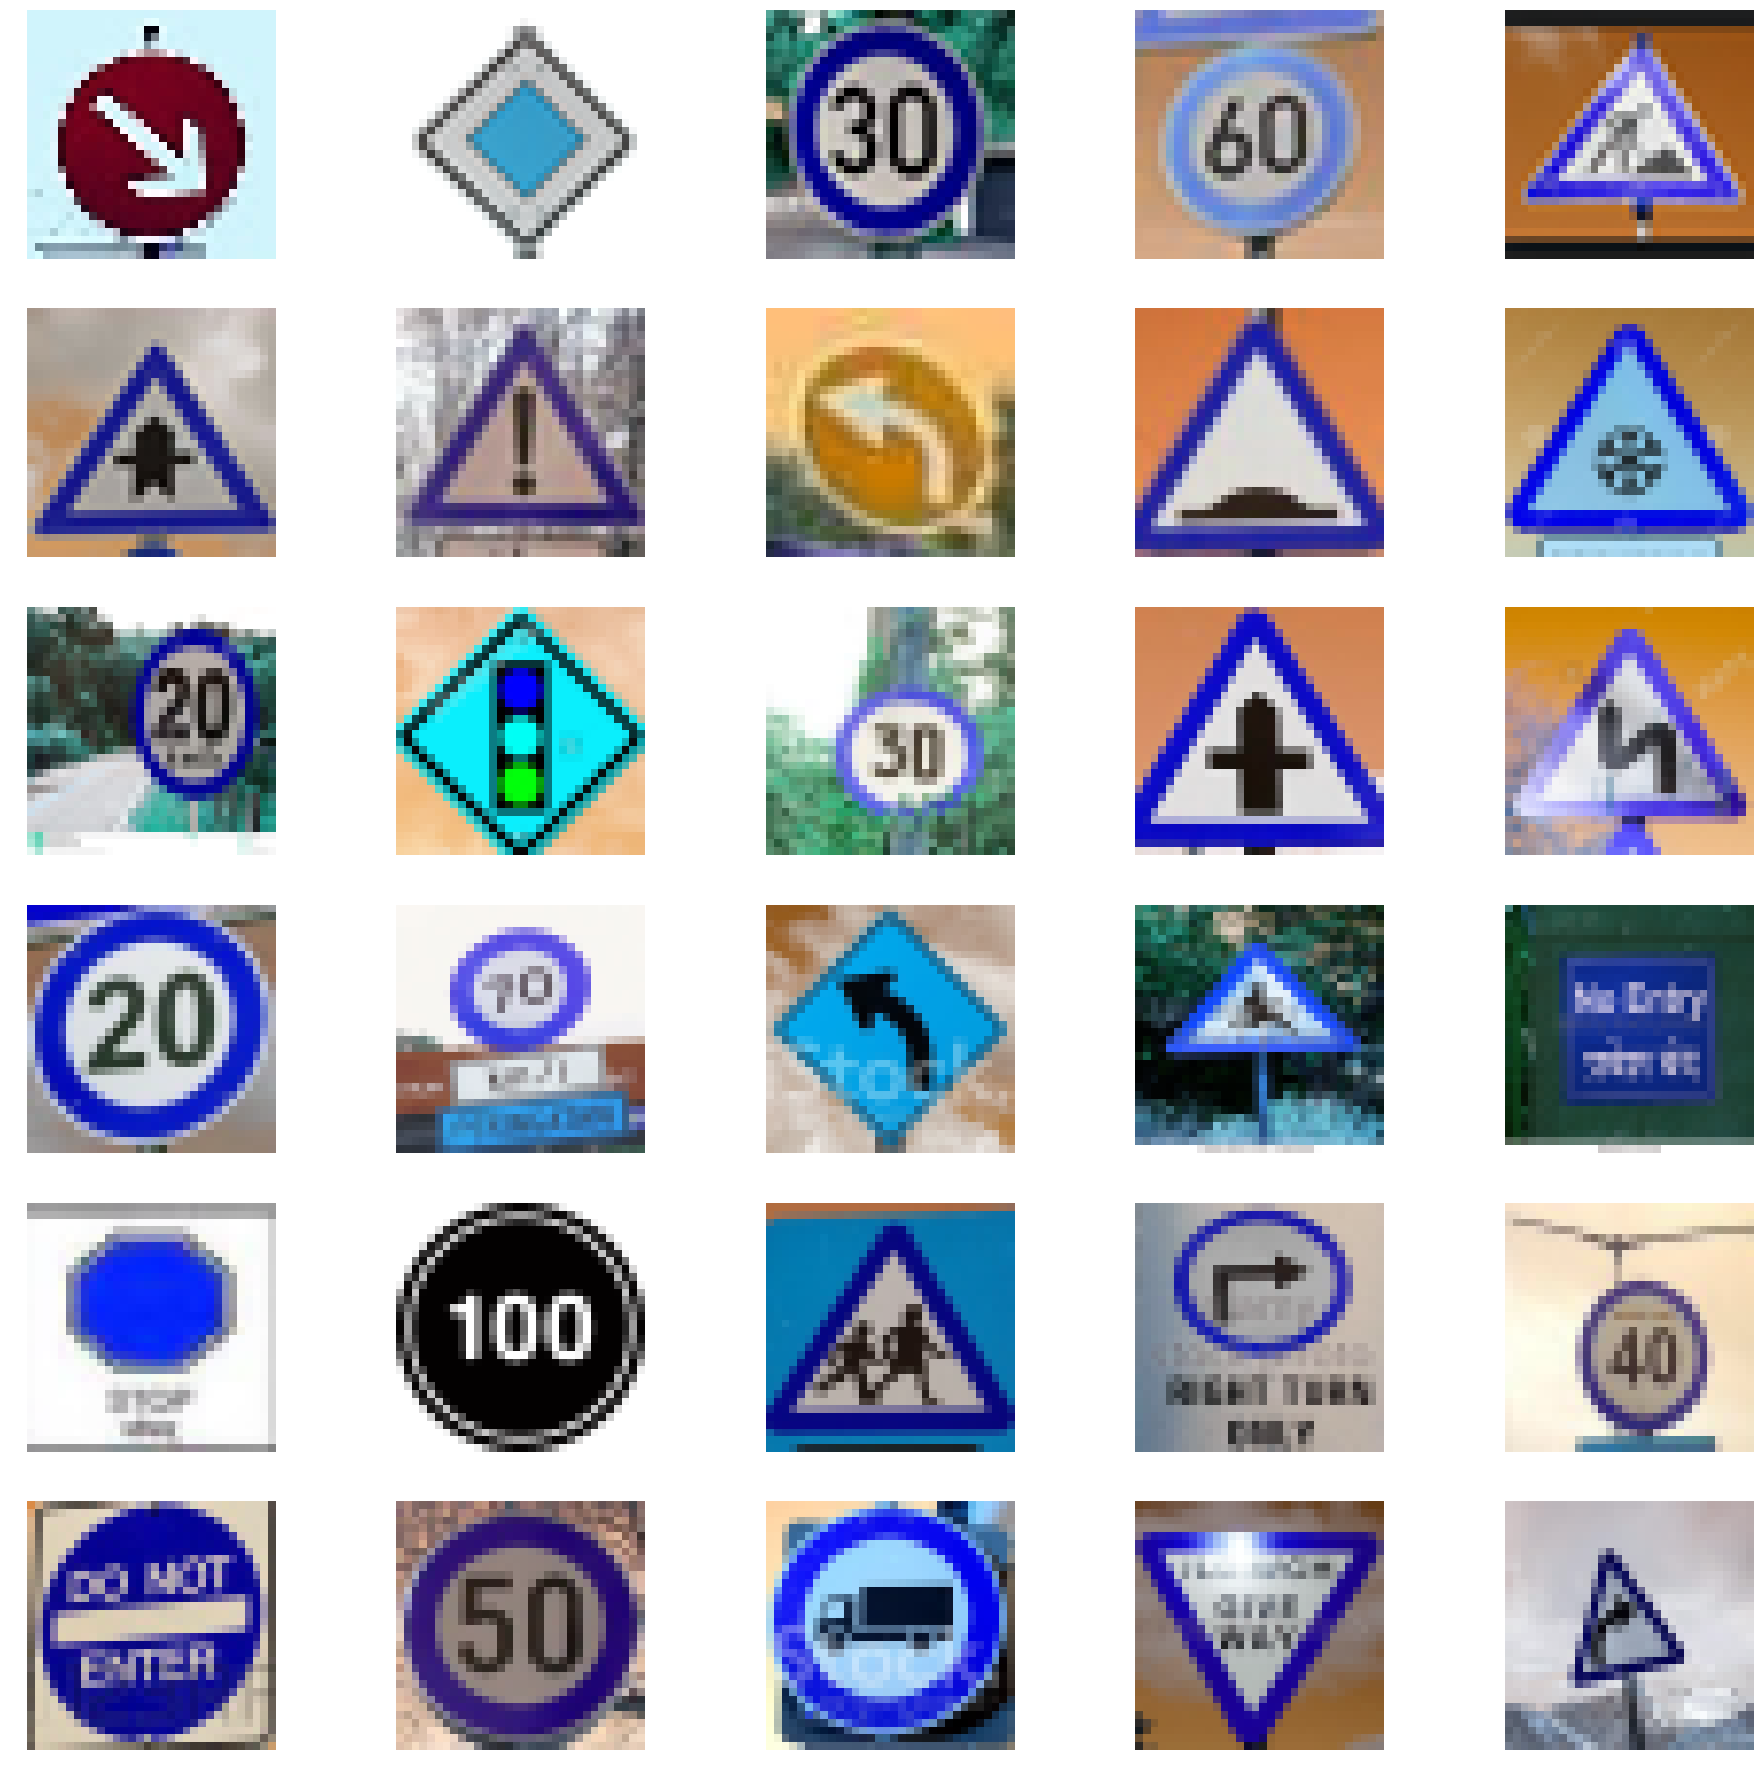

In [13]:
# These are the trial images chosen from the web for prediction which are not part of the train or test set
tsd._plot_images(color_trial_images)

In [15]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
# get the softmax probabilities for 3 best prediction probabilities.

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # model evaluation
    prediction = tf.nn.softmax(model._logits)

    trial_prediction = sess.run(tf.nn.top_k(
        prediction,k=5),
        feed_dict={model._X:gray_trial_images_X , model._pkeep:1.0})

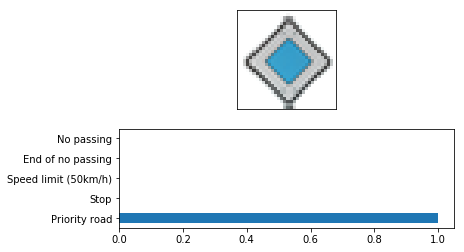

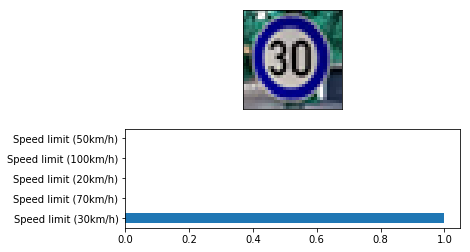

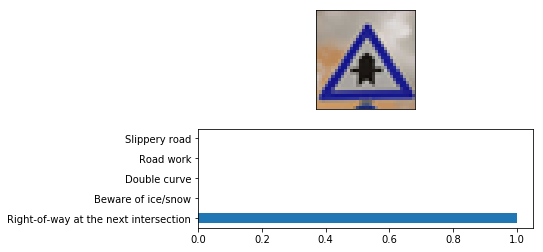

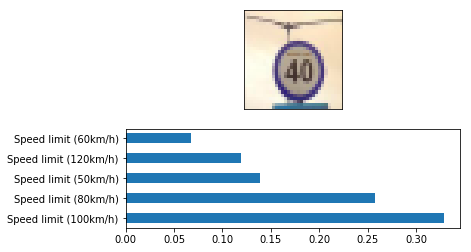

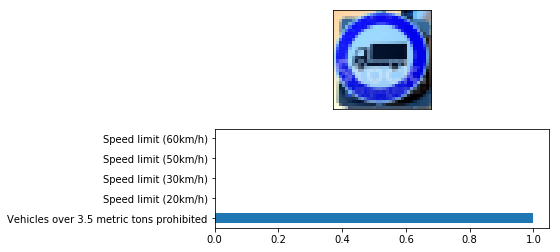

In [18]:
# plot visualization of softmax probabilities
index = np.arange(5)
top_k_prob, top_k_classes = trial_prediction

candidates = [1,2,5,24,27]
for idx,img in enumerate(candidates):
    
    plt.subplot(2,1,1)
    plt.imshow(color_trial_images[img])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    
    plt.subplot(2,1,2)
    plt.barh(index, top_k_prob[img], height=0.5, align='center')
    plt.yticks(index,[tsd._label_sign_names[top_k_classes[img][j]] for j in index] )
    plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model accuracy on the 30 trial images is pretty poor. Only a 50% accuracy. The accuracy on the test dataset is 94.8%.
** Reasons **
1. The images in the trial set are not all part of the traffic sign data. There a number of new images in the trial set that the moel isn;t even aware of like (Speed Limit 40km/hr, Give way etc.,). So the model is bound to make wrong predictions on these hence results in a lower accuracy

Of the 5 trial images that I displayed above 4 of the images were classified correctly, i.e., an accuracy of 80%

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The above 5 trial images say that the model was pretty sure when it predicted the sign.
The 4th trial image couldn't be predicted or doesn't appear in the top_5 predictions because there is no class for a sign with name speed limit - 40km/hr. Hence the model didn't know what to predict, although the model realized that it is related to traffic signs.

1. Image 1 - Priority Road - The model predicts this correctly with 100% certainity

2. Image 2 - Speed Limit 30km/hr - The model predicts this with 100% certainity as well. Also, we can see that in the top 5 predictions, the options are all related to the speed limits. This is something we want and hence talks of the robustness of the model.

3. Image 3 - Right-of-way at the next intersection - The model predicts this correctly with 100% certainity.

4. Image 4 - Speed Limit 40km/hr - The model is not able to predict this because the traffic sign Speed Limit 40km/hr doesn't figure in the 42 class of traffic signs the model is trained on. Yet, in the top k predictions the model correctly recognizes the traffic sign as belong to a speed limit.

5. Image 5 - Vehicles over 3.5 metric tonnes predicted - The prediction is correct. Although the image is taken from the web and is not exactly that of the predicted traffic sign. I assigned it to that class because of its close resemblance to the Vehicles over 3.5 metric tonnes prohoboted class. The model predicted it correctly with 100% certainity.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.